In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix
from tensorflow import keras
from pathlib import Path
from datasets import Dataset, load_dataset
from PIL import Image
from transformers import AutoImageProcessor, AutoFeatureExtractor, TrOCRProcessor, VisionEncoderDecoderModel, DefaultDataCollator
import requests
import torch
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize, ToPILImage
from matplotlib import pyplot as plt
import evaluate
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from transformers import pipeline
import random
import seaborn as sns
#import cv2



In [19]:
csv_input = pd.read_csv('..\privateDir\labels\labels.csv', sep = ';')
csv_input

,ID,Label
0,1,male
1,2,female
2,3,male
3,4,male
4,5,female
...,...,...
121,122,male
122,123,female
123,124,female
124,125,male


In [20]:
#images_labels = dict(csv_input)
images_labels= pd.Series(csv_input.Label.values,index=csv_input.ID).to_dict()
images_labels

{1: 'male',
 2: 'female',
 3: 'male',
 4: 'male',
 5: 'female',
 6: 'female',
 7: 'male',
 8: 'male',
 9: 'male',
 10: 'male',
 11: 'male',
 12: 'female',
 13: 'male',
 14: 'female',
 15: 'male',
 16: 'male',
 17: 'male',
 18: 'female',
 19: 'male',
 20: 'female',
 21: 'male',
 22: 'female',
 23: 'female',
 24: 'female',
 25: 'male',
 26: 'male',
 27: 'female',
 28: 'female',
 29: 'male',
 30: 'male',
 31: 'male',
 32: 'male',
 33: 'male',
 34: 'female',
 35: 'male',
 36: 'female',
 37: 'male',
 38: 'female',
 39: 'male',
 40: 'male',
 41: 'male',
 42: 'male',
 43: 'female',
 44: 'female',
 45: 'female',
 46: 'female',
 47: 'male',
 48: 'male',
 49: 'female',
 50: 'female',
 51: 'female',
 52: 'female',
 53: 'female',
 54: 'female',
 55: 'male',
 56: 'male',
 57: 'female',
 58: 'female',
 59: 'female',
 60: 'male',
 61: 'male',
 62: 'female',
 63: 'male',
 64: 'male',
 65: 'female',
 66: 'male',
 67: 'female',
 68: 'female',
 69: 'female',
 70: 'male',
 71: 'male',
 72: 'male',
 73: 'm

In [84]:
images_labels
sum(value == 'male' for value in images_labels.values())

67

In [21]:
"""Create Dataset: Load images"""
IMAGES = '..\images\segmented'
images_path = Path(IMAGES)


In [24]:
all_images = []
for idx, label in images_labels.items():
    for img_path in (images_path / f'{idx:03}').glob('word*.png'):
        all_images.append({ 'label': label, 'path': img_path })

print(all_images)

[{'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-001.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-002.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-003.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-004.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-005.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-006.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-007.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-008.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-009.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-010.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-011.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-012

In [79]:
#all_images[3324]

{'label': 'male',
 'path': WindowsPath('../images/segmented/119/word-119-022.png')}

In [25]:
"""Create Dataset: Define IDs for target labels"""
labels = ['male', 'female']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label]      = i
    id2label[i]     = label

print(label2id, id2label)

{'male': 0, 'female': 1} {0: 'male', 1: 'female'}


In [26]:
def _generator():
    for l in all_images:
        yield {'label': label2id[l['label']], 
               #'image': np.array(Image.open(l['path']).getdata()).reshape(Image.open(l['path']).size[0], Image.open(l['path']).size[1], 3)}
                'image': Image.open(l['path'])}
        
#pic = Image.open("foo.jpg")
#pix = numpy.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3)



In [97]:
ds=Dataset.from_generator(_generator)
ds = ds.train_test_split(test_size=0.2)
#stratify_by_column = 'label'
#ds['train']['image']
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'image'],
        num_rows: 2784
    })
    test: Dataset({
        features: ['label', 'image'],
        num_rows: 696
    })
})

In [94]:
train_n = len(ds['train']['label'])
train_female_n = sum(ds['train']['label'])
train_male_n = train_n - train_female_n

print(train_n, train_male_n, train_female_n)



2784 1500 1284


In [32]:
ds['train'][0]
#img = x_train[0].resize((300, 300), Image.Resampling.LANCZOS)
#img

{'label': 1,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=446x68>}

In [520]:
#np.asarray(x_train[0])

In [233]:
#'image': np.array(Image.open(l['path']).getdata()).reshape(Image.open(l['path']).size[0], Image.open(l['path']).size[1], 3)}

In [234]:
#def convert(pil_image)-> np.array:
#    # converts PIL image into one-dimensional, reshaped array
#    r = np.asarray(pil_image)
#    nx, ny, nrgb = r.shape
#    s = r.reshape(nx*ny*nrgb)
#    return s/255.0


In [257]:
#def convert(pil_image)-> np.array:
    # converts PIL image into one-dimensional, reshaped array
#    base_width= 300
#    img = pil_image
    #wpercent = (base_width / float(img.size[0]))
    #hsize = int((float(img.size[1]) * float(wpercent)))
#    hsize = 300
#    img = img.resize((base_width, hsize), Image.Resampling.LANCZOS)
#    r = np.asarray(img)
#    nx, ny, nrgb = r.shape
#    s = r.reshape(nx*ny*nrgb)
#    return s/255.0

In [ ]:
#def convert(pil_image)-> np.array:
#    # converts PIL image into one-dimensional, reshaped array
#    base_width= 300
#    img = pil_image
    #wpercent = (base_width / float(img.size[0]))
    #hsize = int((float(img.size[1]) * float(wpercent)))
#    hsize = 300
#    img = img.resize((base_width, hsize), Image.Resampling.LANCZOS)
#    r = np.asarray(img)
#    nx, ny, nrgb = r.shape
#    s = r.reshape(nx*ny*nrgb)
#    return s/255.0

In [29]:
def convert(pil_image)-> np.array:
    # converts PIL image into one-dimensional, reshaped array
    r = np.asarray(pil_image)
    nx, ny, nrgb = r.shape
    s = r.reshape(nx*ny*nrgb)
    s = s/255.0
    return list(s)

In [30]:
CHECKPOINT="google/vit-base-patch16-224-in21k"
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

In [31]:
def tensor_to_image(t) -> Image:
    transform=ToPILImage()
    return transform(t)

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
# in other processors, maybe use 'shortest_edge'
size = (processor.size["height"], processor.size["width"] )
# JV suggests: do not normalize bc these are no food images
#_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])
#_transforms = Compose([Resize(size), ToTensor(), normalize])
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

print(size)
def transforms(examples):
    """Transform the image in the Dataset row."""
    examples["pixel_values"] = np.asarray([convert(tensor_to_image(_transforms(img.convert("RGB")))) for img in examples["image"]])
    examples["label"]= np.asarray([[label] for label in examples['label']]).astype('uint8')
    #print(examples, "\n")
    del examples["image"]
    return examples

ds2 = ds.with_transform(transforms)
#tensor = ds2['train'][0]['pixel_values']

#img = tensor_to_image(tensor)
img = ds2['train'][:]['pixel_values']
#img.shape
#plt.imshow(img)
#plt.show()


(224, 224)


In [33]:
ds2['train'][:]['pixel_values']

KeyboardInterrupt: 

In [351]:
#images = [tensor_to_image(yxi) for yxi in ds2['train'][:]['pixel_values']]
#images

[<PIL.Image.Image image mode=RGB size=224x224>,
 <PIL.Image.Image image mode=RGB size=224x224>,
 <PIL.Image.Image image mode=RGB size=224x224>]

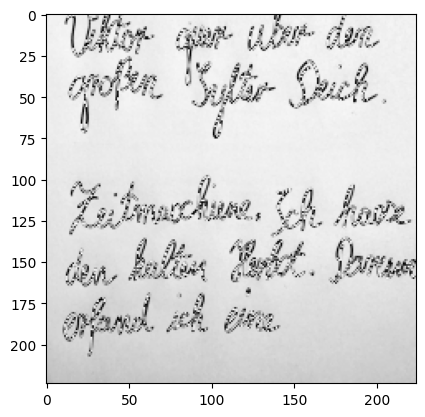

In [356]:
#images = [tensor_to_image(yxi) for yxi in ds2['train'][:]['pixel_values']]
#plt.imshow(images[0], cmap='gray')
#plt.show()

In [345]:
#ds2['train'][:]['pixel_values'] = [tensor_to_image(xi) for xi in ds2['train'][:]['pixel_values']]

In [363]:
#for xi in ds2['train'][:]['pixel_values']:
#    ds2['train'][:]['images'] = tensor_to_image(xi)

In [369]:
#ds2['train'][:]['images']

KeyError: 'images'

In [350]:
#ds2['train'][:]['pixel_values']

[tensor([[[0.9216, 0.9137, 0.9294,  ..., 0.9608, 0.9529, 0.9529],
          [0.9137, 0.9216, 0.9137,  ..., 0.9529, 0.9451, 0.9608],
          [0.9216, 0.9137, 0.9137,  ..., 0.9608, 0.9451, 0.9451],
          ...,
          [0.8824, 0.8824, 0.8824,  ..., 0.9216, 0.9137, 0.9216],
          [0.8745, 0.8824, 0.8824,  ..., 0.9216, 0.9216, 0.9216],
          [0.8667, 0.8824, 0.8824,  ..., 0.9137, 0.9294, 0.9216]],
 
         [[0.9216, 0.9137, 0.9294,  ..., 0.9608, 0.9529, 0.9529],
          [0.9137, 0.9216, 0.9137,  ..., 0.9529, 0.9451, 0.9608],
          [0.9216, 0.9137, 0.9137,  ..., 0.9608, 0.9451, 0.9451],
          ...,
          [0.8824, 0.8824, 0.8824,  ..., 0.9216, 0.9137, 0.9216],
          [0.8745, 0.8824, 0.8824,  ..., 0.9216, 0.9216, 0.9216],
          [0.8667, 0.8824, 0.8824,  ..., 0.9137, 0.9294, 0.9216]],
 
         [[0.9216, 0.9137, 0.9294,  ..., 0.9608, 0.9529, 0.9529],
          [0.9137, 0.9216, 0.9137,  ..., 0.9529, 0.9451, 0.9608],
          [0.9216, 0.9137, 0.9137,  ...,

In [34]:
#(x_train, y_train), (x_test, y_test) = (ds['train']['image'], ds['train']['label']),(ds['test']['image'], ds['test']['label'])
(x_train, y_train), (x_test, y_test) = (ds2['train'][:]['pixel_values'], ds2['train'][:]['label']),(ds2['test'][:]['pixel_values'], ds2['test'][:]['label'])

In [258]:
#x_train2= [convert(xi) for xi in x_train]

In [36]:
x_train.shape, x_test.shape

((2784, 150528), (696, 150528))

In [ ]:
#x_train = x_train/255.0
#x_test = x_test/255.0

In [ ]:
#sklearn expects i/p to be 2d array-model.fit(x_train,y_train)=>reshape to
#2d array
#nsamples, nx, ny, nrgb = x_train.shape
#x_train2 = x_train.reshape((nsamples,nx*ny*nrgb))

In [ ]:
##so,eventually,model.predict() should also be a 2d input
#nsamples, nx, ny, nrgb = x_test.shape
#x_test2 = x_test.reshape((nsamples,nx*ny*nrgb))

In [37]:
model=RandomForestClassifier()

In [38]:
model.fit(x_train,y_train)

c:\Users\Dr. Emilia Boehm\DataScienceCourseSpiced\Capstone\.venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [39]:
y_pred=model.predict(x_test)
y_pred

array([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,

## Model Evaluation

In [40]:
accuracy_score(y_pred,y_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.66      0.59      0.62       420
           1       0.46      0.55      0.50       276

    accuracy                           0.57       696
   macro avg       0.56      0.57      0.56       696
weighted avg       0.58      0.57      0.57       696



In [42]:
confusion_matrix(y_pred,y_test)

array([[246, 174],
       [125, 151]], dtype=int64)

In [48]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

In [52]:
train_rf_predictions = model.predict(x_train)
train_rf_probs = model.predict_proba(x_train)[:, 1]

rf_predictions = model.predict(x_test)
rf_probs = model.predict_proba(x_test)[:, 1]

In [60]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [63]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Recall Baseline: 1.0 Test: 0.46 Train: 1.0
Precision Baseline: 0.47 Test: 0.55 Train: 1.0
Roc Baseline: 0.5 Test: 0.58 Train: 1.0


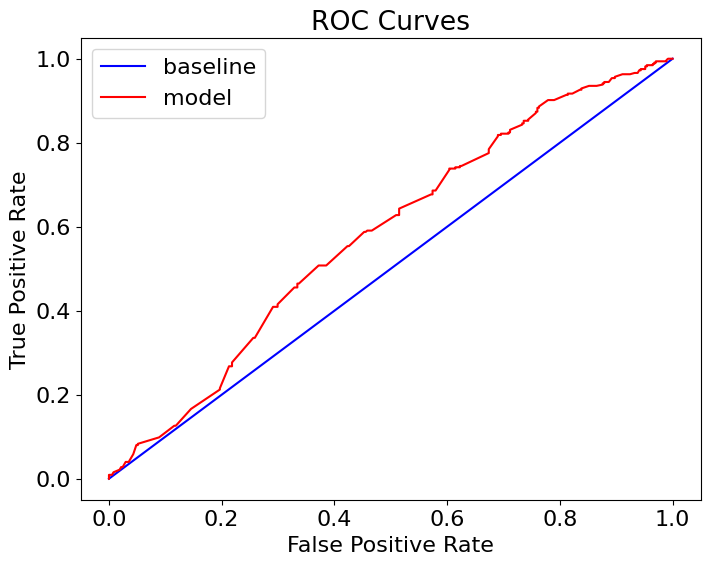

In [61]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Confusion matrix, without normalization
[[246 174]
 [125 151]]


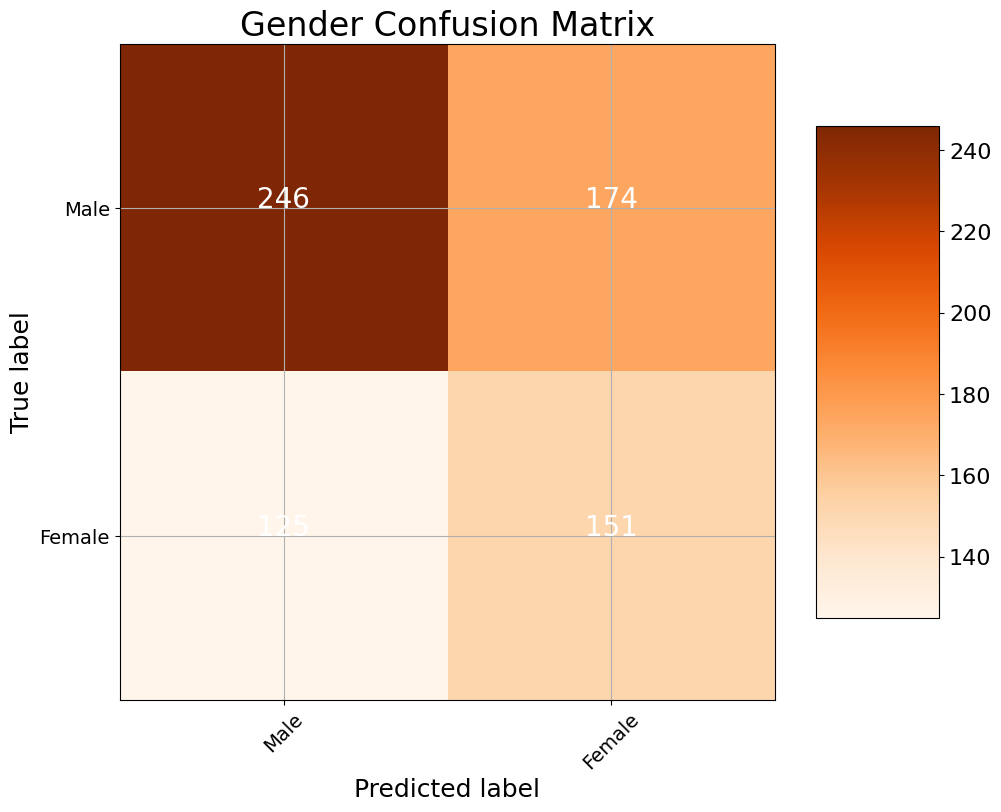

In [95]:
cm = confusion_matrix(y_pred,y_test)
plot_confusion_matrix(cm, classes = ['Male', 'Female'],
                      title = 'Gender Confusion Matrix')